## Implementation of the Bayesian network
### Graphical Representation of the bayesian network

In [1]:
#import libraries for graph builiding and plotting
import networkx as nx
import matplotlib.pyplot as plt

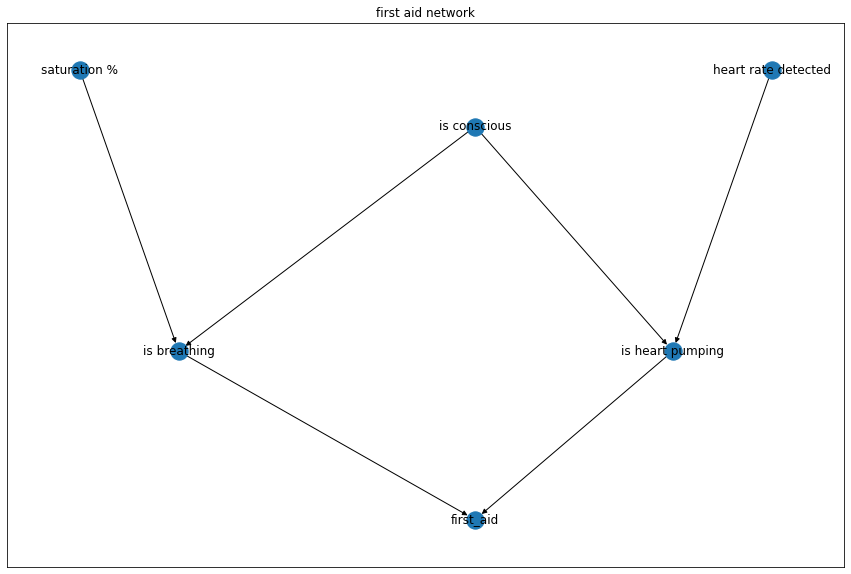

In [2]:
#Create a Directed graph
first_aid_network=nx.DiGraph()
first_aid_network.add_node('saturation %',  npos=(1,10))
first_aid_network.add_node('is conscious',  npos=(5,9))
first_aid_network.add_node('heart rate detected', npos=(8,10))
first_aid_network.add_node('is breathing', npos=(2,5))
first_aid_network.add_node('is heart pumping', npos=(7,5))
first_aid_network.add_node('first_aid', npos=(5,2))
first_aid_network.add_edge('saturation %','is breathing')
first_aid_network.add_edge('is conscious','is breathing')
first_aid_network.add_edge('is conscious','is heart pumping')
first_aid_network.add_edge('heart rate detected','is heart pumping')
first_aid_network.add_edge('is breathing','first_aid')
first_aid_network.add_edge('is heart pumping','first_aid')
pos=nx.get_node_attributes(first_aid_network, 'npos')

#visusalise the graph
plt.figure(figsize=(15,10))
nx.draw_networkx(first_aid_network, pos)
plt.title('first aid network')
plt.show()

### Implemetation of the bayesian network

In [3]:
#Importing relevan library
import numpy as np
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianNetwork

In [4]:
#create the Bayesian Netork as first aid
first_aid= BayesianNetwork([('is_conscious','is_breathing'),
                          ('is_conscious','is_heart_pumping'),
                          ('saturation%','is_breathing'),
                          ('normal_heart_rate_detected','is_heart_pumping'),
                          ('is_breathing','first_aid'),
                          ('is_heart_pumping','first_aid')
                         ])

In [5]:
#Create the relevant cpds: conditional probability distributions
is_conscious_cpd = TabularCPD(
    variable = 'is_conscious',
    variable_card = 2,   # cardinality
    values = [[0.995], [0.005]],
    state_names={'is_conscious':['yes','no']}) 

In [6]:
saturation_cpd=TabularCPD(
    variable = 'saturation%',
    variable_card = 3,   
    values = [[0.99], [0.009],[0.001]],
     state_names={'saturation%':['>95','90-95','<90']})  

In [7]:
normal_heart_rate_cpd=TabularCPD(
    variable = 'normal_heart_rate_detected',
    variable_card = 2,   
    values = [[0.999], [0.001]],
    state_names={'normal_heart_rate_detected':['yes','no']})  # ['yes', 'no']

In [8]:
is_breathing_cpd=TabularCPD(
    variable = 'is_breathing',
    variable_card = 2,   
    values = [[1,0.99,0.8,0.6,0.1,0.0001],  # ['yes']
              [0.0,0.0,0.2,0.4,0.9,0.9999]], #['no']
    evidence = ['is_conscious', 'saturation%'],
    evidence_card = [2,3],
    state_names={'is_breathing':['yes','no'],
                'is_conscious':['yes','no'],
                'saturation%':['>95','90-95','<90']})

In [9]:
is_heart_pumping=TabularCPD(
    variable = 'is_heart_pumping',
    variable_card = 2,   
    values = [[1,0.99,0.9,0.001], # ['yes']
              [0.0,0.01,0.1,0.999]],#['no']
    evidence = ['is_conscious', 'normal_heart_rate_detected'],
    evidence_card = [2,2],
    state_names={'is_heart_pumping':['yes','no'],
                'is_conscious':['yes','no'],
                'normal_heart_rate_detected':['yes','no']})

In [10]:
first_aid_cpd=TabularCPD(
    variable = 'first_aid',
    variable_card = 3,   
    values = [[0.0,0.1,0.1,1.0],# ['full cpr']
              [0.0,0.0,0.89,0], #['mouth-to-mouth']
              [1.0,0.9,0.01,0.0]],#['no rescue']
    evidence = ['is_breathing', 'is_heart_pumping'],
    evidence_card = [2,2],
    state_names={ 'first_aid':['full cpr','mouth2mouth', 'no rescue'],
                 'is_breathing':['yes','no'],
                 'is_heart_pumping':['yes','no']})

In [11]:
#add the cpds to the baysian network
first_aid.add_cpds(is_conscious_cpd,saturation_cpd,normal_heart_rate_cpd,is_breathing_cpd,is_heart_pumping,first_aid_cpd)

In [12]:
#check if cpds were added correctly
first_aid.get_cpds()

[<TabularCPD representing P(is_conscious:2) at 0x1a99923c308>,
 <TabularCPD representing P(saturation%:3) at 0x1a99923cec8>,
 <TabularCPD representing P(normal_heart_rate_detected:2) at 0x1a999248888>,
 <TabularCPD representing P(is_breathing:2 | is_conscious:2, saturation%:3) at 0x1a999254588>,
 <TabularCPD representing P(is_heart_pumping:2 | is_conscious:2, normal_heart_rate_detected:2) at 0x1a999254ac8>,
 <TabularCPD representing P(first_aid:3 | is_breathing:2, is_heart_pumping:2) at 0x1a999251408>]

In [13]:
# we check the nodes that are affected by "is conscious". 
#This means, that the value of this node can change the other nodes
# in the dictionary and viceversa
first_aid.active_trail_nodes('is_conscious')

{'is_conscious': {'first_aid',
  'is_breathing',
  'is_conscious',
  'is_heart_pumping'}}

In [14]:
# we check the nodes that are affected by "saturation%"
first_aid.active_trail_nodes('saturation%')

{'saturation%': {'first_aid', 'is_breathing', 'saturation%'}}

In [15]:
#We can check the model if it is well desinged
first_aid.check_model()

True

In [16]:
#we can display the conditional probabilites given in the cpd cards
print(first_aid.get_cpds('saturation%'))

+--------------------+-------+
| saturation%(>95)   | 0.99  |
+--------------------+-------+
| saturation%(90-95) | 0.009 |
+--------------------+-------+
| saturation%(<90)   | 0.001 |
+--------------------+-------+


In [17]:
#we can get all the independencies for the nodes
first_aid.get_independencies()

(is_conscious ⟂ saturation%, normal_heart_rate_detected)
(is_conscious ⟂ saturation% | is_heart_pumping)
(is_conscious ⟂ saturation% | normal_heart_rate_detected)
(is_conscious ⟂ normal_heart_rate_detected | is_breathing)
(is_conscious ⟂ normal_heart_rate_detected | saturation%)
(is_conscious ⟂ saturation% | is_heart_pumping, normal_heart_rate_detected)
(is_conscious ⟂ first_aid | is_heart_pumping, is_breathing)
(is_conscious ⟂ normal_heart_rate_detected | saturation%, is_breathing)
(is_conscious ⟂ first_aid | is_heart_pumping, normal_heart_rate_detected, is_breathing)
(is_conscious ⟂ first_aid | is_heart_pumping, saturation%, is_breathing)
(is_conscious ⟂ first_aid | is_heart_pumping, normal_heart_rate_detected, saturation%, is_breathing)
(is_heart_pumping ⟂ saturation%)
(is_heart_pumping ⟂ saturation%, is_breathing | is_conscious)
(is_heart_pumping ⟂ saturation% | normal_heart_rate_detected)
(is_heart_pumping ⟂ saturation%, is_breathing | is_conscious, normal_heart_rate_detected)
(is

### Querying Bayesian network

In [18]:
#import relevant libraries
from pgmpy.inference import VariableElimination

C:\Users\kraca\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [19]:
#instanciate the class VariableElimination to start infering probabilites
first_aid_infer=VariableElimination(first_aid)

We will start by infering the initial probability of needing first aid base on the prior probabilities, without further evidence.

In [20]:
#make a query
prob_cpr = first_aid_infer.query(variables = ['first_aid'], joint=False)

In [21]:
#get the results
print(prob_cpr['first_aid'])

+------------------------+------------------+
| first_aid              |   phi(first_aid) |
+========================+==================+
| first_aid(full cpr)    |           0.0004 |
+------------------------+------------------+
| first_aid(mouth2mouth) |           0.0018 |
+------------------------+------------------+
| first_aid(no rescue)   |           0.9978 |
+------------------------+------------------+


As we can see, with the prior probabilites, there is no need for any rescue treatment

We will start with the first query:

1. My friend is has drown in the swimming pool and I managed to take him out. He is unconcious, his smartwatch detects a low saturation value but detects heart rate, what should I do?

In [22]:
#make the query
prob_cpr_drowing = first_aid_infer.query(variables = ['first_aid'], joint=False,evidence={'is_conscious':'no', 'saturation%':'<90','normal_heart_rate_detected':'yes'})
most_probable_drowing=first_aid_infer.map_query(variables = ['first_aid'], evidence={'is_conscious':'no', 'saturation%':'<90','normal_heart_rate_detected':'yes'})
print(prob_cpr_drowing['first_aid'])
print('the best advice is', end=' ')
print(most_probable_drowing['first_aid'])


+------------------------+------------------+
| first_aid              |   phi(first_aid) |
+========================+==================+
| first_aid(full cpr)    |           0.1900 |
+------------------------+------------------+
| first_aid(mouth2mouth) |           0.8009 |
+------------------------+------------------+
| first_aid(no rescue)   |           0.0091 |
+------------------------+------------------+
the best advice is mouth2mouth


From this we can understand that I should carry out mouth to mouth resuscitation

2. My dad is unconcious, however he doesn't wear a fitnes tracker. As instructed by the app, I put his finger next to my phone camera, the app is able to detect his heart rate but I do not know how to check if he is breathing, what should I do?

In [23]:
#make the query
prob_cpr_lost_consciousness_heart_rate_detected = first_aid_infer.query(variables = ['first_aid'], joint=False, evidence={'is_conscious':'no','normal_heart_rate_detected':'yes' })
most_probable_lost_consciousness_heart_rate_detected=first_aid_infer.map_query(variables = ['first_aid'], evidence={'is_conscious':'no','normal_heart_rate_detected':'yes' })
print(prob_cpr_lost_consciousness_heart_rate_detected['first_aid'])
print('the best advice is', end=' ')
print(most_probable_lost_consciousness_heart_rate_detected['first_aid'])


+------------------------+------------------+
| first_aid              |   phi(first_aid) |
+========================+==================+
| first_aid(full cpr)    |           0.0829 |
+------------------------+------------------+
| first_aid(mouth2mouth) |           0.3245 |
+------------------------+------------------+
| first_aid(no rescue)   |           0.5926 |
+------------------------+------------------+
the best advice is no rescue


I should not do anything

3. My grandad is unconcious, the fitness tracker cannot detect heart rate, it can detect a very low saturation. What Should I do?

In [24]:
#make the query
prob_cpr_lost_consciousness_low_saturation_no_heart_rate = first_aid_infer.query(variables = ['first_aid'], joint=False, evidence={'is_conscious':'no', 'saturation%':'<90','normal_heart_rate_detected':'no'})
most_prob_lost_consciousness_low_saturation_no_heart_rate = first_aid_infer.map_query(variables = ['first_aid'], evidence={'is_conscious':'no', 'saturation%':'<90', 'normal_heart_rate_detected':'no'})
print(prob_cpr_lost_consciousness_low_saturation_no_heart_rate['first_aid'])
print('the best advice is', end=' ')
print(most_prob_lost_consciousness_low_saturation_no_heart_rate['first_aid'])


+------------------------+------------------+
| first_aid              |   phi(first_aid) |
+========================+==================+
| first_aid(full cpr)    |           0.9990 |
+------------------------+------------------+
| first_aid(mouth2mouth) |           0.0009 |
+------------------------+------------------+
| first_aid(no rescue)   |           0.0001 |
+------------------------+------------------+
the best advice is full cpr


I certainly should carry out full CPR

Even tough, with the first aid bayesian network, I could query other questions which would give me the probability of the inputs or the intermidiate nodes, given the output, this is not the purpose of the app, hence I prefer not to ask these questions.